In [5]:
!pip install torchvision


In [12]:
# Real-Time Video Colorization - Interactive Notebook
# Save as: notebooks/real_time_video_colorization.ipynb

"""
This notebook demonstrates training, evaluation, and real-time testing 
of a video colorization model using your folder structure.

- Training videos assumed in data/raw_videos/ (*.mp4)
- Test/demo videos in data/test_videos/ (*.mp4)
- GUI and inference scripts already supported for model switching and visualization.
"""

# --- 1. Setup and Imports ---

import os
from pathlib import Path
import sys
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Add project roots for imports
# root = Path(".").absolute().parent if Path(".").name == "notebooks" else Path(".").absolute()
# sys.path += [
#     str(root / "src"),
#     str(root / "models"),
#     str(root / "config"),
# ]
# import os
# from pathlib import Path
# import sys

# # Set the root directory of your project (adjust if notebook is nested differently)
# root = Path.cwd()  # If notebook runs from project root
# if root.name == "notebooks":
#     root = root.parent  # If notebook runs from notebooks subfolder

# print(f"Setting project root to: {root}")

# # Clear existing entries to avoid conflicts
# sys.path = [p for p in sys.path if str(root) not in p]

import sys, os
from pathlib import Path

root = Path.cwd()
if root.name == "notebooks":
    root = root.parent

# Ensure project paths
for p in [root, root/"src", root/"models", root/"config"]:
    p = str(p.resolve())
    if p not in sys.path:
        sys.path.insert(0, p)

# 🔧 Add venv site-packages explicitly (Windows)
venv_site = root / "venv" / "Lib" / "site-packages"
if venv_site.exists():
    venv_site = str(venv_site.resolve())
    if venv_site not in sys.path:
        sys.path.insert(0, venv_site)

# Sanity check
import torch, importlib.util
print("Python:", sys.executable)
print("Has torchvision?", importlib.util.find_spec("torchvision") is not None)
# Add required paths
sys.path.insert(0, str(root.resolve()))
sys.path.insert(0, str((root / "src").resolve()))
sys.path.insert(0, str((root / "models").resolve()))
sys.path.insert(0, str((root / "config").resolve()))

print("sys.path set to:")
for p in sys.path[:5]:
    print(f"- {p}")

# -- Imports from your project (make sure kernels see your venv!) --
from src.dataset import ColorizationDataset, get_dataloader
from src.video_processor import VideoProcessor
from models.colorization_net import ColorizationNet, FastColorizationNet, AttentionColorizationNet
from config import TrainingConfig
from src.inference import RealTimeColorizer, BatchColorizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Python: D:\colorization_task6\semantic_video_colorization\venv\Scripts\python.exe
Has torchvision? True
sys.path set to:
- D:\colorization_task6\semantic_video_colorization\config
- D:\colorization_task6\semantic_video_colorization\models
- D:\colorization_task6\semantic_video_colorization\src
- D:\colorization_task6\semantic_video_colorization
- D:\colorization_task6\semantic_video_colorization\config
Device: cpu


In [15]:
# --- 2. Data Preparation (Extract Training Frames) ---

raw_videos_dir = Path("data/raw_videos")
processed_dir = Path("data/processed_frames")

# Only extract if not already processed, uses default prepare_data.py script
if not (processed_dir / "train" / "color").exists():
    os.makedirs(processed_dir, exist_ok=True)
    !python ../scripts/prepare_data.py --input ../data/raw_videos --output ../data/processed_frames --frame-rate 1 --max-frames 200 --target-size 256x256 --workers 2
train_color_images = list((processed_dir / "train" / "color").glob("*.jpg"))
print(f"Training images: {len(train_color_images)}")


Found 6 video files
Extracting 1.0 fps, max 200 frames per video
Target size: (256, 256)

Processed 6 videos
Extracted 84 total frames
Training samples: 42
Validation samples: 26
Data saved to: ..\data\processed_frames
Training images: 0



Processing videos: 100%|##########| 6/6 [01:39<00:00, 16.65s/it]


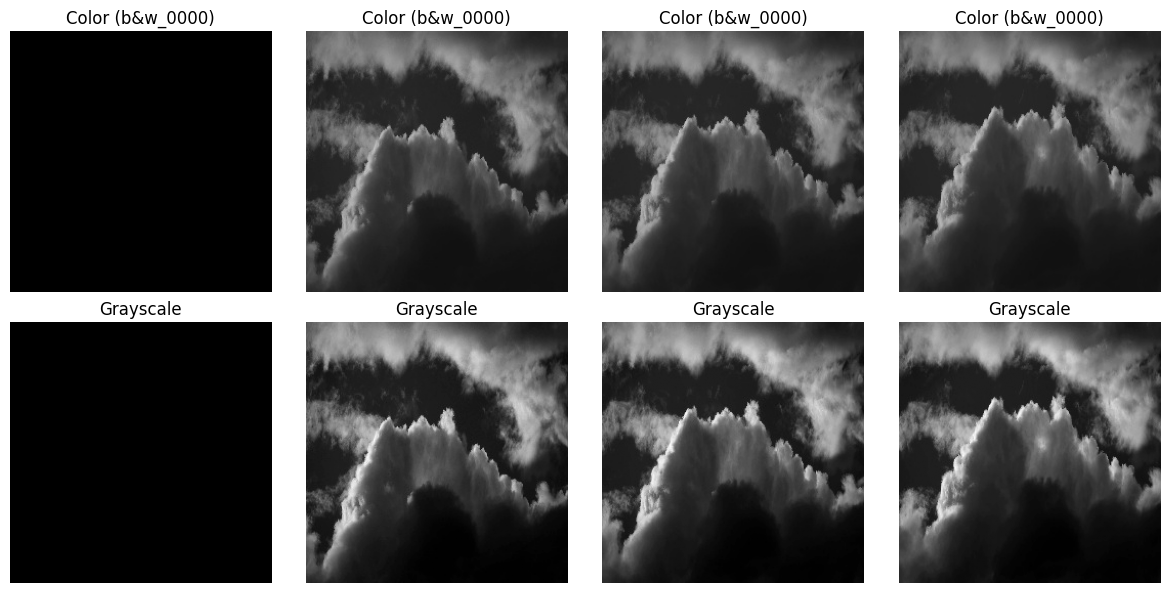

In [21]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

# Adjust the processed_dir to be relative to notebook, pointing to project root level
processed_dir = Path("../data/processed_frames")

# Load training color images from the correct absolute/relative path
train_color_images = list((processed_dir / "train" / "color").glob("*.jpg"))

if len(train_color_images) == 0:
    print("No training images found for visualization.")
else:
    n_show = min(4, len(train_color_images))
    fig, axs = plt.subplots(2, n_show, figsize=(n_show * 3, 6))
    for idx, path in enumerate(train_color_images[:n_show]):
        gray_path = processed_dir / "train" / "grayscale" / path.name
        color_img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
        gray_img = cv2.imread(str(gray_path), cv2.IMREAD_GRAYSCALE)
        axs[0, idx].imshow(color_img)
        axs[0, idx].set_title(f"Color ({path.name[:8]})")
        axs[0, idx].axis("off")
        axs[1, idx].imshow(gray_img, cmap="gray")
        axs[1, idx].set_title("Grayscale")
        axs[1, idx].axis("off")
    plt.tight_layout()
    plt.show()


In [23]:
# --- 4. Create DataLoaders ---

BATCH_SIZE = 8
train_loader = get_dataloader("../data/processed_frames", split='train', batch_size=BATCH_SIZE, num_workers=0)
val_loader = get_dataloader("../data/processed_frames", split='validation', batch_size=BATCH_SIZE, num_workers=0)

Loaded 42 train samples
Loaded 26 validation samples


In [24]:
# --- 5. Model Setup (Full/Real-Time Switchable) ---

# Model options
models_available = {
    "ColorizationNet": ColorizationNet,
    "FastColorizationNet": FastColorizationNet,
    "AttentionColorizationNet": AttentionColorizationNet
}
MODEL_TYPE = "FastColorizationNet"  # Change to try!

model = models_available[MODEL_TYPE](input_channels=1, output_channels=3).to(device)
print(f"{MODEL_TYPE} loaded {sum(p.numel() for p in model.parameters()):,} parameters")

FastColorizationNet loaded 441,987 parameters


In [25]:
# --- 6. Training (Short Demo Loop) ---

import torch.nn as nn, torch.optim as optim
criterion = nn.L1Loss()  # Quick loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 2  # For full training, increase this!

for epoch in range(EPOCHS):
    model.train()
    t_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        gray = batch["grayscale"].to(device)
        color = batch["color"].to(device)
        optimizer.zero_grad()
        out = model(gray)
        loss = criterion(out, color)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
    print(f"Train Loss: {t_loss / len(train_loader):.5f}")

Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:27<00:00,  4.52s/it]


Train Loss: 0.28475


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:19<00:00,  3.27s/it]

Train Loss: 0.17320


In [2]:
def colorize_video_frames(test_video_path, model, device, num_frames=4):
    cap = cv2.VideoCapture(str(test_video_path))
    if not cap.isOpened():
        raise ValueError(f"Cannot open video file: {test_video_path}")
    
    frame_results = []
    count = 0
    while cap.isOpened() and count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        inp = torch.from_numpy(gray).float().unsqueeze(0).unsqueeze(0) / 255
        inp = inp.to(device)
        with torch.no_grad():
            out = model(inp)
        out_np = out[0].cpu().numpy()
        out_img = ((out_np + 1) / 2).clip(0, 1).transpose(1, 2, 0)
        frame_results.append((gray, out_img))
        count += 1
    cap.release()
    print(f"Captured {len(frame_results)} frames from video")

    return frame_results

from pathlib import Path
test_video = Path("../data/test_videos/architecture_test.mp4")
video_results = colorize_video_frames(test_video, model, device, num_frames=4)

if len(video_results) == 0:
    print("No frames to display. Check video path or contents.")
else:
    fig, axs = plt.subplots(len(video_results), 2, figsize=(6, 3*len(video_results)))
    for idx, (gray, colorized) in enumerate(video_results):
        axs[idx, 0].imshow(gray, cmap='gray')
        axs[idx, 0].set_title("Grayscale Input")
        axs[idx, 0].axis('off')
        axs[idx, 1].imshow(colorized)
        axs[idx, 1].set_title("Model Output")
        axs[idx, 1].axis('off')
    plt.tight_layout()
    plt.show()


NameError: name 'model' is not defined

In [3]:
# --- 9. Save Model for Use in GUI and Batch Inference ---
os.makedirs("checkpoints", exist_ok=True)
torch.save({"model_state_dict": model.state_dict()}, "checkpoints/best_model_demo.pth")
print("Model saved as checkpoints/best_model_demo.pth")

NameError: name 'os' is not defined